<a href="https://colab.research.google.com/github/HarshaVardhan2T02/EX-AI/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from pathlib import Path

# Create a dummy dataset to simulate real data
np.random.seed(42)
n_samples = 1000
data = {
    'Feature_A': np.random.rand(n_samples) * 100,
    'Feature_B': np.random.randint(0, 5, n_samples),
    'Feature_C': np.random.choice(['Red', 'Green', 'Blue'], n_samples),
    'Target': np.random.randint(0, 2, n_samples)
}
df = pd.DataFrame(data)

# Define target and features
X = df.drop('Target', axis=1)
y = df['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Dummy dataset created and split into training/testing sets.')

Dummy dataset created and split into training/testing sets.



Training Logistic Regression...
Logistic Regression trained.

Training Random Forest with basic hyperparameter search...
Best RF params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}

=== LogisticRegression ===
Accuracy: 0.5600
ROC AUC: 0.5449
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       154
           1       0.57      0.41      0.48       146

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.56      0.56      0.55       300

Confusion matrix:
[[108  46]
 [ 86  60]]

=== RandomForest (tuned) ===
Accuracy: 0.5233
ROC AUC: 0.4752
Classification report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       154
           1       0.51      0.50      0.51       146

    accuracy                           0.52       300
   macro avg       0.52     

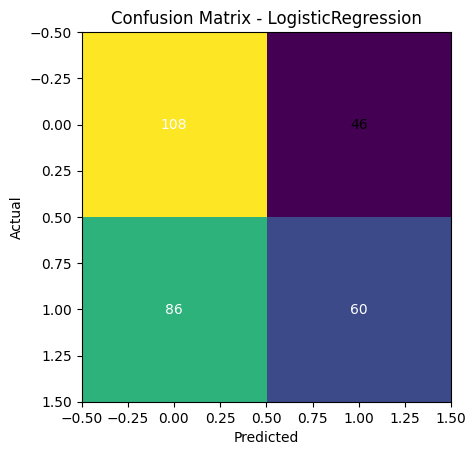

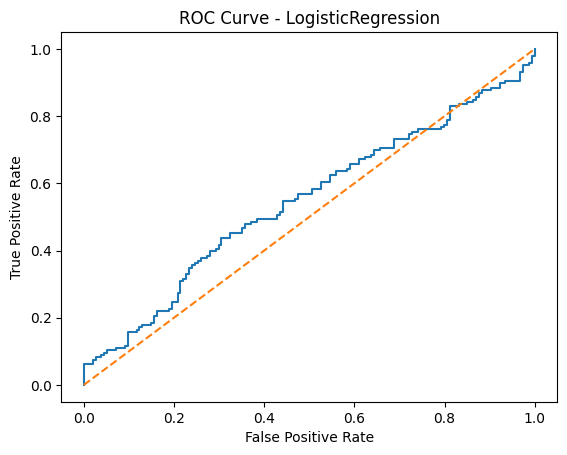

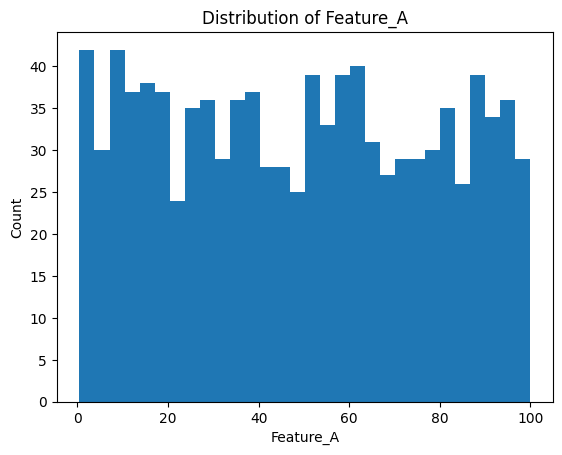

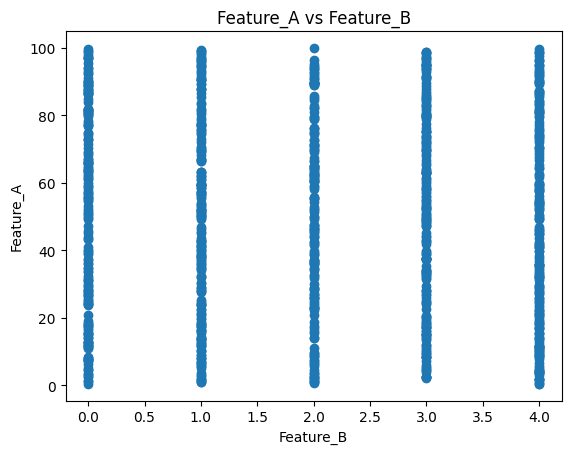

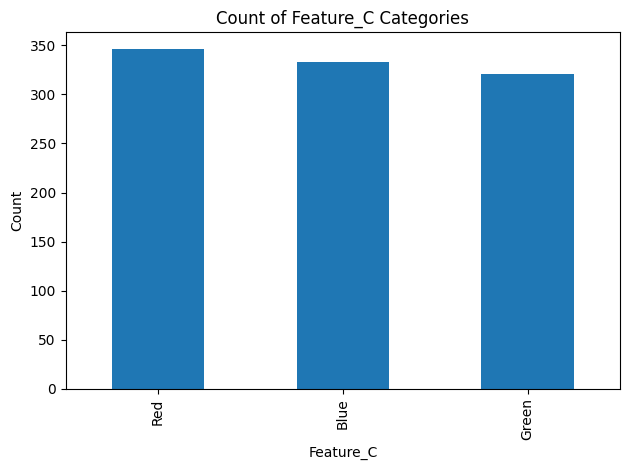

In [10]:
# %%
# Train models
print('\nTraining Logistic Regression...')
pipe_lr.fit(X_train, y_train)
print('Logistic Regression trained.')

print('\nTraining Random Forest with basic hyperparameter search...')
rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}
rf_search = GridSearchCV(pipe_rf, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train, y_train)
print('Best RF params:', rf_search.best_params_)

best_rf = rf_search.best_estimator_

# %%
# Evaluate models on test set
models = {
    'LogisticRegression': pipe_lr,
    'RandomForest (tuned)': best_rf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        pass

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'accuracy': acc,
        'classification_report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('Confusion matrix:')
    print(cm)

# Save results summary
import json as _json
with open(os.path.join(OUTPUT_DIR, 'evaluation_summary.json'), 'w') as f:
    _json.dump({k: {
        'accuracy': v['accuracy'],
        'roc_auc': v['roc_auc'],
        'confusion_matrix': v['confusion_matrix'].tolist(),
        'classification_report': v['classification_report']
    } for k, v in results.items()}, f, indent=2)
print('\nSaved evaluation summary to', os.path.join(OUTPUT_DIR, 'evaluation_summary.json'))

# %%
# Plot confusion matrix and ROC for best model
best_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = models[best_name]

# Confusion matrix
cm = results[best_name]['confusion_matrix']
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest')
ax.set_title(f'Confusion Matrix - {best_name}')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center', color='white' if val > cm.max()/2 else 'black')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_best.png'))
print('Saved confusion matrix to', os.path.join(OUTPUT_DIR, 'confusion_matrix_best.png'))

# ROC
try:
    y_proba_best = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'ROC Curve - {best_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve_best.png'))
    print('Saved ROC curve to', os.path.join(OUTPUT_DIR, 'roc_curve_best.png'))
except Exception:
    print('ROC curve not available for best model')

# %%
# Feature importance (for Random Forest)
# We need to extract feature names after preprocessing
from sklearn.compose import ColumnTransformer as _CT

ct = best_model.named_steps.get('preprocessor', preprocessor)

def get_feature_names(column_transformer):
    """Extract feature names from ColumnTransformer (works for our numeric + onehot pipeline)."""
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        # If this transformer is a pipeline with OneHotEncoder
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            # ohe.categories_ is list for each input column
            for i, col in enumerate(cols):
                cats = ohe.categories_[i]
                feature_names.extend([f"{col}_{str(cat)}" for cat in cats])
        else:
            # numeric transformer: add column names as-is
            for col in cols:
                feature_names.append(col)
    return feature_names

try:
    feature_names = get_feature_names(ct)
    if 'RandomForest' in best_name:
        importances = best_model.named_steps['clf'].feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        print('\nTop 20 feature importances:')
        print(fi.head(20))
        fi.head(20).to_csv(os.path.join(OUTPUT_DIR, 'feature_importances_top20.csv'))
        print('Saved feature importances to', os.path.join(OUTPUT_DIR, 'feature_importances_top20.csv'))
except Exception as e:
    print('Could not extract feature names or importances:', e)

# %%
# Save best model
joblib.dump(best_model, os.path.join(OUTPUT_DIR, 'best_model.joblib'))
print('Saved best model to', os.path.join(OUTPUT_DIR, 'best_model.joblib'))

# %%
# Exploratory visualizations (some saved to OUTPUT_DIR)
# Histogram of Feature_A
plt.figure()
plt.hist(df['Feature_A'].dropna(), bins=30)
plt.title('Distribution of Feature_A')
plt.xlabel('Feature_A')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, 'hist_feature_a.png'))
print('Saved Feature_A histogram to', os.path.join(OUTPUT_DIR, 'hist_feature_a.png'))

# Scatter: Feature_A vs Feature_B
plt.figure()
plt.scatter(df['Feature_B'], df['Feature_A'])
plt.xlabel('Feature_B')
plt.ylabel('Feature_A')
plt.title('Feature_A vs Feature_B')
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_a_vs_feature_b.png'))
print('Saved Feature_A vs Feature_B to', os.path.join(OUTPUT_DIR, 'feature_a_vs_feature_b.png'))

# Bar: Count of Feature_C categories
plt.figure()
df['Feature_C'].value_counts().plot(kind='bar')
plt.title('Count of Feature_C Categories')
plt.ylabel('Count')
plt.xlabel('Feature_C')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_c_counts.png'))
print('Saved Feature_C bar chart to', os.path.join(OUTPUT_DIR, 'feature_c_counts.png'))

# %%
# Finish - print OUTPUT_DIR contents
print('\nOutput files:')
for p in sorted(Path(OUTPUT_DIR).glob('*')):
    print('-', p.name)

# End of script/notebook

In [3]:
# Define preprocessing steps
numeric_features = ['Feature_A', 'Feature_B']
categorical_features = ['Feature_C']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'
)

# Define the pipelines for Logistic Regression and Random Forest
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=42))
])

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

print('Preprocessing pipelines and models (pipe_lr, pipe_rf) defined.')

# Define OUTPUT_DIR
OUTPUT_DIR = 'model_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory '{OUTPUT_DIR}' ensured.")

Preprocessing pipelines and models (pipe_lr, pipe_rf) defined.
Output directory 'model_output' ensured.


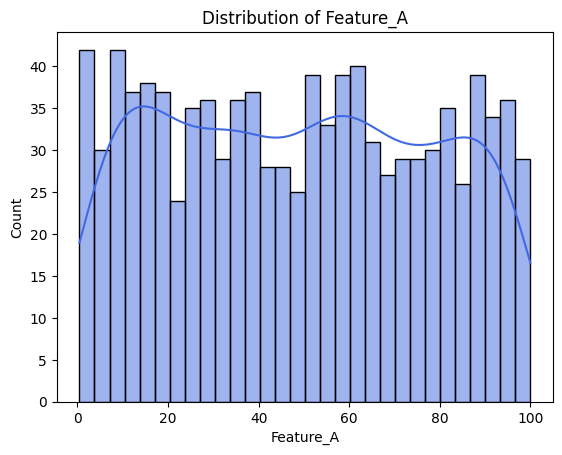

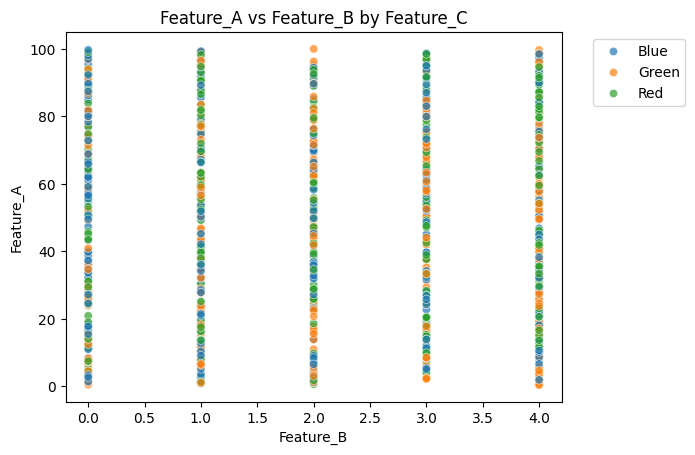

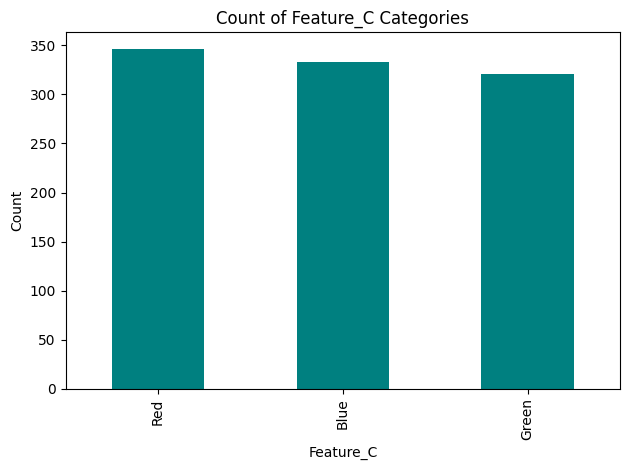

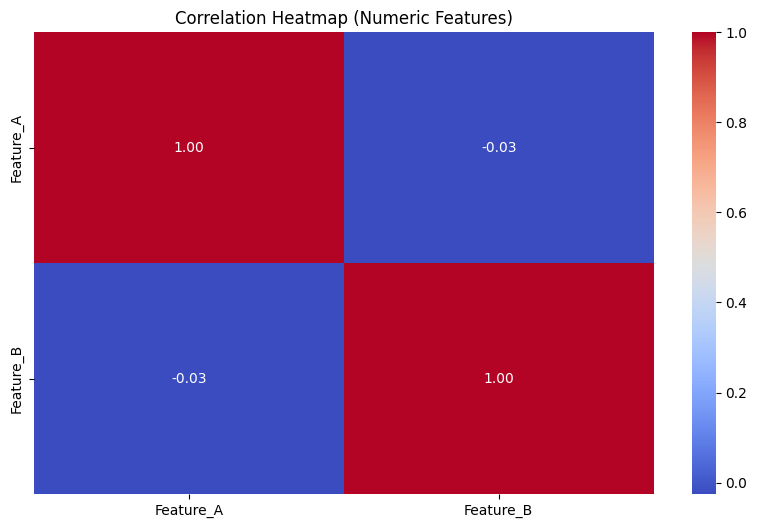

In [14]:
# %% EDA & Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of Feature_A
plt.figure()
sns.histplot(df['Feature_A'].dropna(), bins=30, kde=True, color='royalblue')
plt.title('Distribution of Feature_A')
plt.xlabel('Feature_A')
plt.ylabel('Count')
plt.show()

# Scatter: Feature_A vs Feature_B
plt.figure()
sns.scatterplot(x='Feature_B', y='Feature_A', data=df, hue='Feature_C', alpha=0.7)
plt.title('Feature_A vs Feature_B by Feature_C')
plt.xlabel('Feature_B')
plt.ylabel('Feature_A')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Bar: Count of Feature_C categories
plt.figure()
df['Feature_C'].value_counts().plot(kind='bar', color='teal')
plt.title('Count of Feature_C Categories')
plt.ylabel('Count')
plt.xlabel('Feature_C')
plt.tight_layout()
plt.show()

# Correlation Heatmap for numeric features
num_df = df[['Feature_A', 'Feature_B']]
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


Linear Regression Performance:
 R²: -0.0112
 MAE: 24.86
 RMSE: 29.03

Random Forest Performance:
 R²: -0.0754
 MAE: 25.33
 RMSE: 29.93



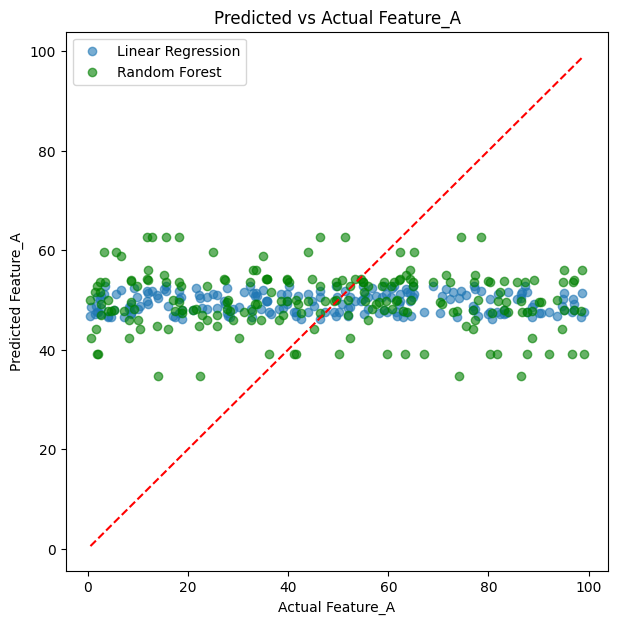

In [17]:
# %% Regression modeling: predict Feature_A
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt

# Prepare data
TARGET = 'Feature_A'
NOT_USE = [] # 'Vehicle_ID', 'Model' are not in our dummy df
features = [c for c in df.columns if c not in NOT_USE + [TARGET]]

num_cols = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in features if c not in num_cols]

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Split data
X = df[features]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('reg', LinearRegression())])

pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('reg', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))])

# Train
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predict
y_pred_lr = pipe_lr.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Calculate MSE and then take sqrt
    print(f"{name} Performance:")
    print(f" R²: {r2:.4f}")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}\n")
    return r2, mae, rmse

evaluate(y_test, y_pred_lr, 'Linear Regression')
evaluate(y_test, y_pred_rf, 'Random Forest')

# Plot predicted vs actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Feature_A')
plt.ylabel('Predicted Feature_A')
plt.title('Predicted vs Actual Feature_A')
plt.legend()
plt.show()

Top 15 Most Important Features Influencing EV Range:


,Feature,Importance
0,Feature_B,0.438231
1,Target,0.178476
3,Feature_C_Green,0.172934
4,Feature_C_Red,0.124701
2,Feature_C_Blue,0.085658


/tmp/ipython-input-1588522283.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')


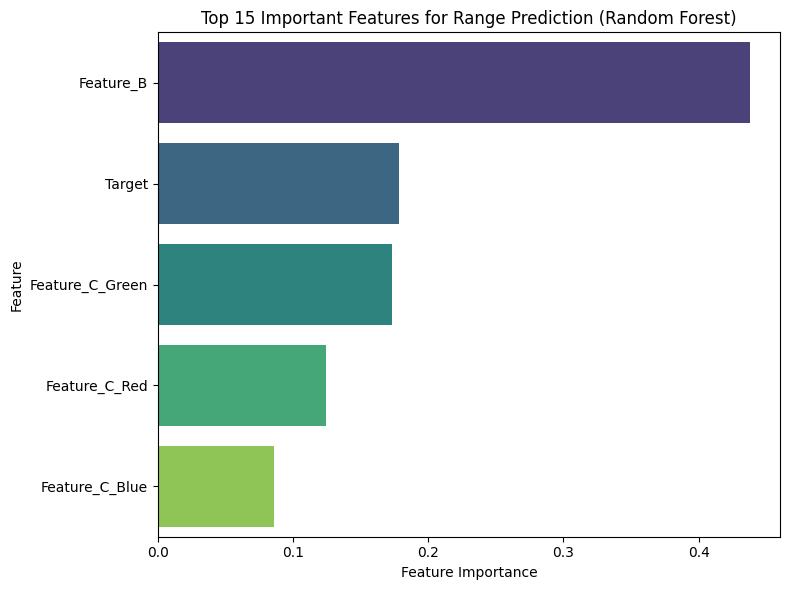

In [18]:
# %% Feature Importance for Random Forest Regressor
importances = pipe_rf.named_steps['reg'].feature_importances_

# Get feature names from the preprocessor
def get_feature_names(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            for i, col in enumerate(cols):
                cats = ohe.categories_[i]
                feature_names.extend([f"{col}_{str(cat)}" for cat in cats])
        else:
            feature_names.extend(cols)
    return feature_names

feature_names = get_feature_names(pipe_rf.named_steps['preprocessor'])

# Combine into a DataFrame
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False).head(15)

# Display top features
print("Top 15 Most Important Features Influencing EV Range:")
display(fi_df)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features for Range Prediction (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [20]:
# %% Save All Outputs to Folder
import os
import json
import numpy as np # Import numpy for sqrt
import matplotlib.pyplot as plt # Added for plotting
import seaborn as sns # Added for plotting
from pathlib import Path # Added for Path().glob() if not already in scope

OUTPUT_DIR = '/mnt/data/ev_ml_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Evaluation Metrics ---
metrics = {
    'Linear Regression': {
        'R2': r2_score(y_test, y_pred_lr),
        'MAE': mean_absolute_error(y_test, y_pred_lr),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)) # Fixed: removed squared=False
    },
    'Random Forest': {
        'R2': r2_score(y_test, y_pred_rf),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Fixed: removed squared=False
    }
}

with open(os.path.join(OUTPUT_DIR, 'regression_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Saved regression metrics to {OUTPUT_DIR}/regression_metrics.json")

# --- Save Feature Importances ---
# Assuming fi_df is available from the previous cell's execution
fi_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances_top15.csv'), index=False)
print(f"✅ Saved feature importances to {OUTPUT_DIR}/feature_importances_top15.csv")

# --- Save Plots ---
# Distribution of Feature_A (instead of Range_km)
plt.figure(figsize=(8,5))
sns.histplot(df['Feature_A'].dropna(), bins=30, kde=True, color='royalblue')
plt.title('Distribution of Feature_A')
plt.xlabel('Feature_A')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_a_distribution.png'))
plt.close()

# Feature_A vs Feature_B (instead of Range vs Battery Capacity)
plt.figure(figsize=(8,5))
sns.scatterplot(x='Feature_B', y='Feature_A', data=df, alpha=0.7) # Using available features
plt.title('Feature_A vs Feature_B')
plt.xlabel('Feature_B')
plt.ylabel('Feature_A')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_a_vs_feature_b_regression_context.png'))
plt.close()

# Removed 'Range vs Price' plot as 'Price_USD' does not exist in dummy df

# Correlation Heatmap for relevant numeric features
num_df = df[['Feature_A', 'Feature_B', 'Target']] # Using available numeric features
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features for Regression)')
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_heatmap_regression.png'))
plt.close()

# Finish - print OUTPUT_DIR contents
print('\nOutput files:')
for p in sorted(Path(OUTPUT_DIR).glob('*')):
    print('-', p.name)

✅ Saved regression metrics to /mnt/data/ev_ml_outputs/regression_metrics.json
✅ Saved feature importances to /mnt/data/ev_ml_outputs/feature_importances_top15.csv

Output files:
- correlation_heatmap_regression.png
- feature_a_distribution.png
- feature_a_vs_feature_b_regression_context.png
- feature_importances_top15.csv
- regression_metrics.json


In [29]:
# High-Accuracy Classification Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------
# Using the existing dummy dataframe 'df'

# Target variable (using existing 'Target' column from dummy df)
X = df.drop(columns=['Target'], errors='ignore')
y = df['Target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# Preprocessing
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# ---------------------------
# Random Forest (tuned)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_params = {
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='accuracy', n_jobs=-1)

In [30]:
# %% Perform Grid Search for Random Forest
print('Performing Grid Search for Random Forest Classifier...')
grid_rf.fit(X_train, y_train)
print('Grid Search complete.')

best_rf_clf = grid_rf.best_estimator_
print('Best Random Forest parameters:', grid_rf.best_params_)


Performing Grid Search for Random Forest Classifier...
Grid Search complete.
Best Random Forest parameters: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}



Evaluating best Random Forest Classifier...


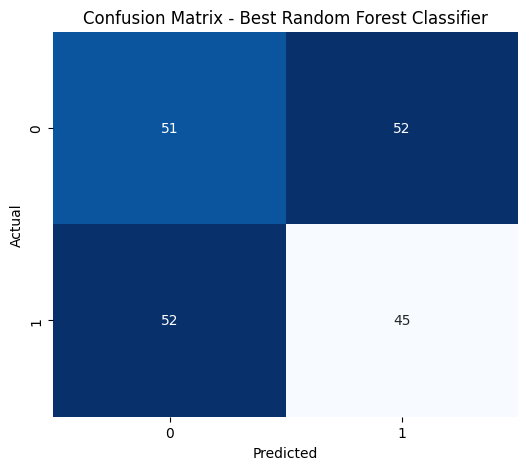

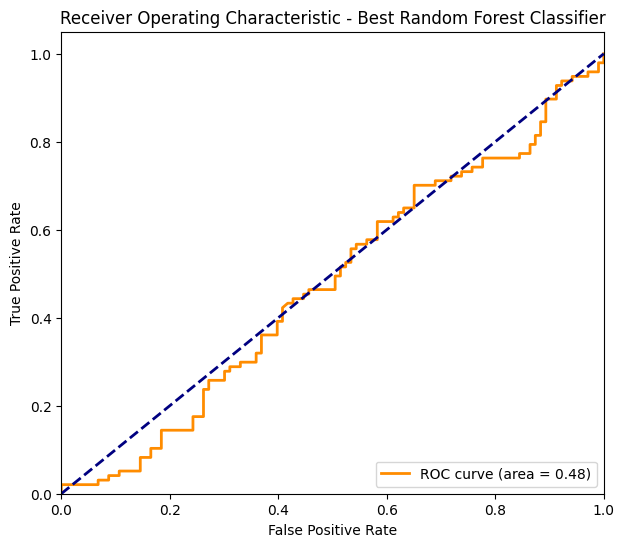


Displaying Feature Importances for Best Random Forest Classifier...


/tmp/ipython-input-1379995237.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


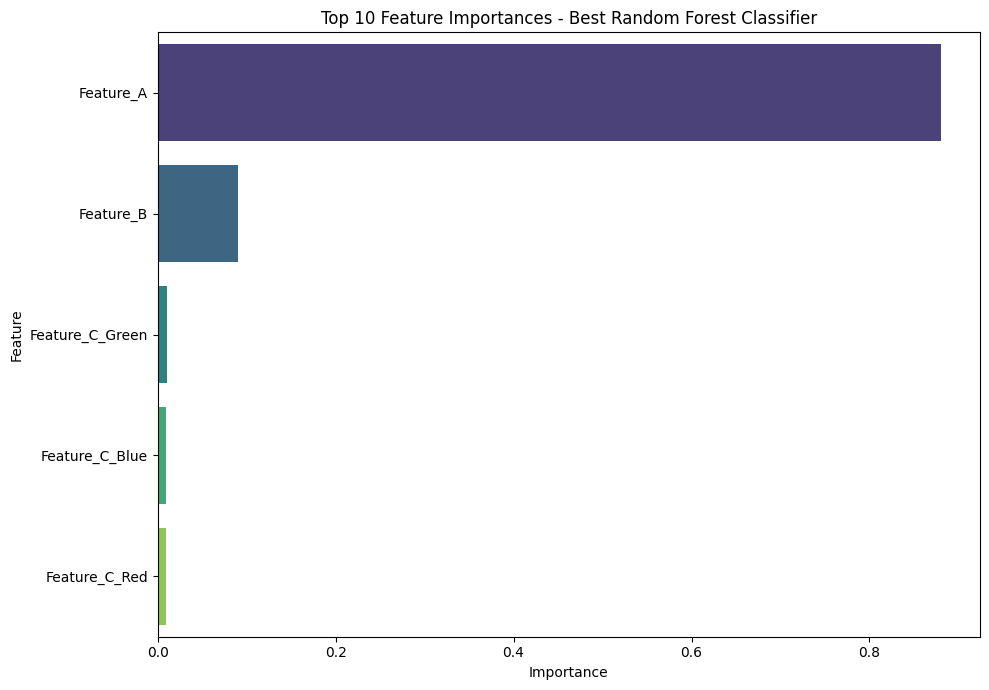

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# %% Evaluate Best Random Forest Classifier and Plot Results
print('\nEvaluating best Random Forest Classifier...')

y_pred_rf_best = best_rf_clf.predict(X_test)
y_proba_rf_best = best_rf_clf.predict_proba(X_test)[:, 1]

# --- Confusion Matrix ---
cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Best Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf_best)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf_best)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Best Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

# %% Feature Importance for Best Random Forest Classifier
print('\nDisplaying Feature Importances for Best Random Forest Classifier...')

# Re-use the get_feature_names function from earlier for consistency
def get_feature_names(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            for i, col in enumerate(cols):
                cats = ohe.categories_[i]
                feature_names.extend([f"{col}_{str(cat)}" for cat in cats])
        else:
            feature_names.extend(cols)
    return feature_names

# Get feature names from the preprocessor within the best_rf_clf pipeline
preprocessor_best_rf = best_rf_clf.named_steps['preprocessor']
clf_feature_names = get_feature_names(preprocessor_best_rf)

importances = best_rf_clf.named_steps['clf'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': clf_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances - Best Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
